# Логистическая регрессия на основе тензорного CP разложения

### Абстракт

Проект выполнен на основе статьи "Learning Predictors from Multidimensional Data with Tensor Factorizations". Здесь представлена реализация логистической регресси с использованием CP разложения на тензора весов. Результат работы алгоритма проверялся на датасете MNIST. Алгоритм сравнивался с классической простейшей логистической регрессией, реализованной самостоятельно. Качество сравнивалось на основе accuracy метрики, по времени работы алгоритмов и по количеству используемой памяти (в данном случае упрощенно сравнивались количества весов в каждой из модели)

In [1]:
import sys
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.io import loadmat
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

from modules.linear_model import * #
from modules.CP_log import *
from modules.utils import *

In [4]:
# Загружаем MNIST

mnist = loadmat("./mnist-original.mat")
mnist_data = mnist["data"].T
mnist_label = mnist["label"][0]

# Используем только 750 цифр, повторяя за статьей
num_samples = 750

random_indices = np.random.choice(mnist_data.shape[0], num_samples, replace=False)

mnist_data = mnist_data[random_indices, :]
mnist_label = mnist_label[random_indices]

In [16]:
mnist = loadmat("./mnist-original.mat")
mnist_data = mnist["data"].T
mnist_label = mnist["label"][0]

idx_not1 = np.where(mnist_label != 1)[0]
idx_1 = np.where(mnist_label == 1)[0]
random_indices = np.random.choice(mnist_data[idx_not1].shape[0], mnist_data[idx_1].shape[0], replace=False)

mnist_data = mnist_data[np.r_[random_indices, idx_1], :]
mnist_label = mnist_label[np.r_[random_indices, idx_1]]


In [17]:
# Предобработка данных
#Нормализуем данные
mnist_data_normalized = normalize(mnist_data)
#Приводим к тензорному виду 28 * 28
mnist_data_tensor_normalized = mnist_data_normalized.reshape(mnist_data.shape[0], 28,28) 

X_train, X_test, Y_train, Y_test = train_test_split(mnist_data_normalized, mnist_label, test_size=0.20, random_state=42)
Y_train = Y_train.reshape(Y_train.shape[0],1)
Y_test = Y_test.reshape(Y_test.shape[0],1)

print("The shape of the training set feature matrix is:", X_train.shape)
print("The shape of the training label vector is:", Y_train.shape)
print("The shape of the test set feature matrix is:", X_test.shape)
print("The shape of the test label vector is:", Y_test.shape)

Y_train_1=(Y_train==1).astype(int)
Y_test_1=(Y_test==1).astype(int)

Xt_train, Xt_test, Yt_train, Yt_test = train_test_split(mnist_data_tensor_normalized, mnist_label, test_size=0.20, random_state=42)

print("The shape of the training set feature matrix is:", Xt_train.shape)
print("The shape of the training label vector is:", Yt_train.shape)
print("The shape of the test set feature matrix is:", Xt_test.shape)
print("The shape of the test label vector is:", Yt_test.shape)

Yt_train.reshape(Yt_train.shape[0],1)
Yt_train=(Yt_train==1).astype(int)
Yt_train_1=Yt_train * 2 - 1 #Делаем метки для 1 и не единицы равными 1 и -1

# Creating new testing label vectors for each digit for the one-vs-all methode
Yt_test.reshape(Yt_test.shape[0],1)
Yt_test=(Yt_test==1).astype(int)
Yt_test_1=Yt_test * 2 -1


The shape of the training set feature matrix is: (12603, 784)
The shape of the training label vector is: (12603, 1)
The shape of the test set feature matrix is: (3151, 784)
The shape of the test label vector is: (3151, 1)
The shape of the training set feature matrix is: (12603, 28, 28)
The shape of the training label vector is: (12603,)
The shape of the test set feature matrix is: (3151, 28, 28)
The shape of the test label vector is: (3151,)


In [18]:
# Вызываем основой класс логистической регрессии с CP разложением
CP = CP_LogisticRegression(CP_rank=2) 
start = time.time()
log_dict = CP.fit(Xt_train[:], Yt_train_1[:], max_iterations=50)
end = time.time()
cp_reconstructed = CP.reconstructTensor(solved_dict=log_dict, tensor_n_dim=2) # reconstruct tensor
print(f"time consumed {end - start} s")
predict = []
for t in Xt_test:
    predict.append(expit(np.sum(t * cp_reconstructed)))
predict = np.array(predict)

Current Iteration: 1
Current Difference in Error Value: 0.6148967301565879

Current Iteration: 2
Current Difference in Error Value: 0.05746685587244971

Current Iteration: 3
Current Difference in Error Value: 0.014429352143567664

Current Iteration: 4
Current Difference in Error Value: 0.0026306101902678902

Current Iteration: 5
Current Difference in Error Value: 0.0

RRRR
time consumed 25.14494490623474 s


Интересно, что несмотря на использование логистической сигмоиды, результирующая переменная распределена не от 0 до 1. Соответственно приходится подбирать порог для классификации единицы, что происходит ниже. Делаем это визуально, так как не требуется большая точность.

<AxesSubplot:>

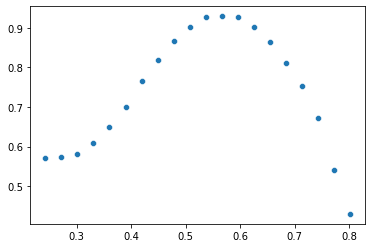

In [19]:
from sklearn.metrics import accuracy_score
import seaborn as sns


signif = {}
for p in np.linspace(predict.min(), predict.max(), 20):
    predict_ = predict.copy()
    predict_[np.where(predict_ > p)] = 1
    predict_[np.where(predict_ <= p)] = -1
    signif[p] = accuracy_score(Yt_test_1, predict_)

sns.scatterplot(x=signif.keys(), y = signif.values())

In [26]:
p = 0.55
predict_ = predict.copy()
predict_[np.where(predict_ > p)] = 1
predict_[np.where(predict_ <= p)] = -1
accuracy_score(Yt_test_1, predict_)

0.9314503332275468

### CP Результат
- Accuracy = 0.93 для порога отсечения p = 0.55
- Время нахождения разложения - 25 c
- Количество переменных - $28*2*rang = 28*2*2 = 112$

# Классический Log_reg

Ниже реализована примитивная логистическая регрессия

In [27]:
# creating a normalization function
from scipy.special import expit, logit

def normalize(data):
    mean = np.mean(data, axis=1, keepdims=True)
    std = np.std(data, axis=1, keepdims=True)
    data_normalized = (data - mean)/std
    return data_normalized

def initializer(nbr_features):
    W = np.zeros((nbr_features,1))
    B = 0
    return W, B


def sigmoid(x):
    s = expit(x)
    return s


def ForwardBackProp(X, Y, W, B):
    m = X.shape[0] 
    dw = np.zeros((W.shape[0],1))
    dB = 0
    
    Z = np.dot(X,W)+B
    Yhat = sigmoid(Z) 
    J = -(1/m)*(np.dot(Y.T,np.log(Yhat))+np.dot((1-Y).T,np.log(1-Yhat)))
    dW = (1/m)*np.dot(X.T,(Yhat-Y))
    dB = (1/m)*np.sum(Yhat-Y)
    return J, dW, dB


def predict(X,W,B):
    Yhat_prob = sigmoid(np.dot(X,W)+B)
    Yhat = np.round(Yhat_prob).astype(int)
    return Yhat, Yhat_prob


def gradient_descent(X, Y, W, B, alpha, max_iter):
    i=0
    RMSE = 1
    cost_history=[]
    
    # setup toolbar
    toolbar_width = 20
    sys.stdout.write("[%s]" % ("" * toolbar_width))
    sys.stdout.flush()
    sys.stdout.write("\b" * (toolbar_width+1)) # return to start of line, after '['
    
    while (i<max_iter)&(RMSE>10e-6):
        J, dW, dB = ForwardBackProp(X,Y,W,B)
        W = W - alpha*dW
        B = B - alpha*dB
        cost_history.append(J)
        Yhat, _ = predict(X,W,B)
        RMSE = np.sqrt(np.mean(Yhat-Y)**2)
        i+=1
        if i%50==0:
            sys.stdout.write("=")
            sys.stdout.flush()
    
    sys.stdout.write("]\n") # this ends the progress bar
    return cost_history, W, B, i



# Creating the model function which trains a model and return its parameters. 

def LogRegModel(X_train, X_test, Y_train, Y_test, alpha, max_iter):
    
    nbr_features = X_train.shape[1]
    W, B = initializer(nbr_features)
    cost_history, W, B, i = gradient_descent(X_train, Y_train, W, B, alpha, max_iter)
    Yhat_train, _ = predict(X_train, W, B)
    Yhat, _ = predict(X_test, W, B)
    
    train_accuracy = accuracy_score(Y_train, Yhat_train)
    test_accuracy = accuracy_score(Y_test, Yhat)
    conf_matrix = confusion_matrix(Y_test, Yhat, normalize='true')
    
    model = {"weights": W,
            "bias": B,
            "train_accuracy": train_accuracy,
            "test_accuracy": test_accuracy,
            "confusion_matrix": conf_matrix,
            "cost_history": cost_history}
    return model





In [28]:
print('Progress bar: 1 step each 50 iteration')
start = time.time()
model_1 = LogRegModel(X_train[:], X_test[:], Y_train_1[:], Y_test_1[:], alpha=0.01, max_iter=1000)
end = time.time()
print(f"time consumed {end - start} s")
print('Training completed!')

# Checking the accuracy of the model

print('The training accuracy of the model',model_1['train_accuracy'])
print('The test accuracy of the model',model_1['test_accuracy'])

Progress bar: 1 step each 50 iteration
[====================]
time consumed 7.342891693115234 s
Training completed!
The training accuracy of the model 0.9780211060858526
The test accuracy of the model 0.9800063471913678


### CP Результат
- Accuracy = 0.98 для порога отсечения p = 0.5
- Время нахождения разложения - 7 c
- Количество переменных - $28*28*750 = 784$ 

In [179]:
import h5py
hf_train = h5py.File("./archive/train_point_clouds.h5", "r")  
hf_test = h5py.File("./archive/test_point_clouds.h5", "r")  


In [180]:
def cube (dots):
    cub = np.zeros((16,16,16))
    ndots = dots.shape[0]
    for dot in dots:
        if dot[0] > 0.5:
            dot[0] = 0.5
        elif dot[0] < -0.5:
            dot[0] = -0.5
        if dot[1] > 0.5:
            dot[1] = 0.5
        elif dot[1] < -0.5:
            dot[1] = -0.5
        if dot[2] > 0.5:
            dot[2] = 0.5
        elif dot[2] < -0.5:
            dot[2] = -0.5
        dot[0] += 0.5
        dot[1] += 0.5
        dot[2] += 0.5
        n1 = round(dot[0]/0.0625)
        n2 = round(dot[1]/0.0625)
        n3 = round(dot[2]/0.0625)
        if n1 == 16:
            n1 = 15
        if n2 == 16:
            n2 = 15
        if n3 == 16:
            n3 = 15
        cub[n1][n2][n3] += 1/ndots
        #if cub[n1][n2][n3] != 0:
        #    print(cub[n1][n2][n3])
    return cub

In [244]:
hf_train_ones = []
for i in range(1000):
    if hf_train[str(i)].attrs['label'] == 1:
        hf_train_ones.append(i)

hf_test_ones = []
for i in range(1000):
    if hf_test[str(i)].attrs['label'] == 1:
        hf_test_ones.append(i)

In [207]:
len(hf_train_ones)

116

In [247]:
len(hf_test_ones)

126

In [252]:
X_3d_train = []
y_3d_train = []
X_d_train = []

dots = 500

for i in range(1000):
    #inds = np.sort(np.random.choice(hf_train[str(i)]['points'].shape[0], dots, replace=False))
    cub = cube(hf_train[str(i)]['points'][:, : ])
    #hf_train[str(i)]['points'][inds, : ]
    X_3d_train.append(cub)
    X_d_train.append(cub.reshape(-1))
    y_3d_train.append(hf_train[str(i)].attrs['label'])
"""
for i in hf_train_ones:
    cub = cube(hf_train[str(i)]['points'][:, : ])
    #hf_train[str(i)]['points'][inds, : ]
    X_3d_train.append(cub)
    X_d_train.append(cub.reshape(-1))
    y_3d_train.append(hf_train[str(i)].attrs['label'])
"""

"\nfor i in hf_train_ones:\n    cub = cube(hf_train[str(i)]['points'][:, : ])\n    #hf_train[str(i)]['points'][inds, : ]\n    X_3d_train.append(cub)\n    X_d_train.append(cub.reshape(-1))\n    y_3d_train.append(hf_train[str(i)].attrs['label'])\n"

In [253]:
X_3d_test = []
y_3d_test = []
X_d_test = []

for i in range(100):
    #inds = np.sort(np.random.choice(hf_test[str(i)]['points'].shape[0], dots, replace=False))
    cub = cube(hf_test[str(i)]['points'][:, : ])
    X_3d_test.append(cub)
    #X_d_test.append(np.array(hf_test[str(i)]['points'][inds,  : ]).reshape(-1))
    X_d_test.append(cub.reshape(-1))
    y_3d_test.append(hf_test[str(i)].attrs['label'])
"""
for i in hf_test_ones:
    #inds = np.sort(np.random.choice(hf_test[str(i)]['points'].shape[0], dots, replace=False))
    cub = cube(hf_test[str(i)]['points'][:, : ])
    X_3d_test.append(cub)
    #X_d_test.append(np.array(hf_test[str(i)]['points'][inds,  : ]).reshape(-1))
    X_d_test.append(cub.reshape(-1))
    y_3d_test.append(hf_test[str(i)].attrs['label'])
"""

"\nfor i in hf_test_ones:\n    #inds = np.sort(np.random.choice(hf_test[str(i)]['points'].shape[0], dots, replace=False))\n    cub = cube(hf_test[str(i)]['points'][:, : ])\n    X_3d_test.append(cub)\n    #X_d_test.append(np.array(hf_test[str(i)]['points'][inds,  : ]).reshape(-1))\n    X_d_test.append(cub.reshape(-1))\n    y_3d_test.append(hf_test[str(i)].attrs['label'])\n"

In [254]:

y_3d_train= np.array(y_3d_train)
y_3d_train_1 = (y_3d_train==1).astype(int)*2-1
X_3d_train = np.array(X_3d_train)
X_d_train = np.array(X_d_train)

y_3d_test= np.array(y_3d_test)
y_3d_test_1 = (y_3d_test==1).astype(int)*2-1
X_3d_test = np.array(X_3d_test)
X_d_test = np.array(X_d_test)


In [255]:
import time
CP_ = CP_LogisticRegression(CP_rank=3) # instantiating class
start = time.time()
log_dict = CP_.fit(X_3d_train, y_3d_train_1, max_iterations=50, C = 0.0005)
end = time.time()
cp_reconstructed = CP_.reconstructTensor(solved_dict=log_dict, tensor_n_dim=3) # reconstruct tensor
print(f"time consumed {end - start} s")
predict = []
for t in X_3d_test:
    predict.append(expit(np.sum(t * cp_reconstructed)))
predict = np.array(predict)

Current Iteration: 1
Current Difference in Error Value: 0.42740734587839957

Current Iteration: 2
Current Difference in Error Value: 0.013207734500759183

Current Iteration: 3
Current Difference in Error Value: 0.022051433421908018

Current Iteration: 4
Current Difference in Error Value: 0.05023046705497669

Current Iteration: 5
Current Difference in Error Value: 0.12393945640052789

Current Iteration: 6
Current Difference in Error Value: 0.007163753652863369

Current Iteration: 7
Current Difference in Error Value: 0.08439497367652748

Current Iteration: 8
Current Difference in Error Value: 0.03988667928253464

Current Iteration: 9
Current Difference in Error Value: 0.013865046455864949

Current Iteration: 10
Current Difference in Error Value: 0.0

time consumed 103.15441679954529 s


In [256]:
np.sort(predict)

array([0.05996419, 0.07054684, 0.07109756, 0.07294562, 0.07455397,
       0.07525136, 0.07654591, 0.076565  , 0.0776859 , 0.07854041,
       0.0792476 , 0.08017942, 0.08018738, 0.08073989, 0.08242908,
       0.08272462, 0.08292976, 0.08302612, 0.0837289 , 0.08388393,
       0.08436424, 0.08494856, 0.08496631, 0.08498133, 0.08612557,
       0.08641401, 0.08650982, 0.08689026, 0.08690433, 0.08717436,
       0.08775416, 0.08798574, 0.08806667, 0.08831568, 0.0887708 ,
       0.08930864, 0.08966643, 0.09073381, 0.0909141 , 0.09114377,
       0.09152766, 0.09305205, 0.09318542, 0.09321941, 0.09422662,
       0.09581123, 0.09596698, 0.09604055, 0.09612557, 0.09684879,
       0.09752537, 0.09781412, 0.09799422, 0.09820102, 0.09863459,
       0.09909012, 0.09926204, 0.10035978, 0.10036306, 0.10076727,
       0.100793  , 0.10186757, 0.10231603, 0.10299462, 0.10394341,
       0.10445419, 0.10468441, 0.10506548, 0.10518416, 0.10553766,
       0.10576736, 0.10581506, 0.10593522, 0.10594774, 0.10744

In [32]:
np.argmin(predict)

93

<AxesSubplot:>

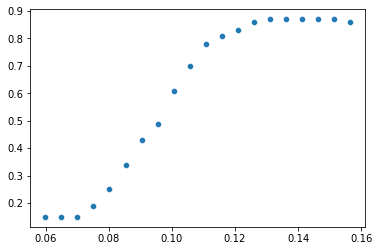

In [257]:
from sklearn.metrics import accuracy_score
import seaborn as sns


signif = {}
for p in np.linspace(predict.min(), predict.max(), 20):
    predict_ = predict.copy()
    predict_[np.where(predict_ > p)] = 1
    predict_[np.where(predict_ <= p)] = -1
    signif[p] = accuracy_score(y_3d_test_1, predict_)

sns.scatterplot(x=signif.keys(), y = signif.values())

In [260]:
p = 0.14
predict_ = predict.copy()
predict_[np.where(predict_ > p)] = 1
predict_[np.where(predict_ <= p)] = -1
accuracy_score(y_3d_test_1, predict_)

0.87

In [262]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_d_train, y_3d_train_1)
pred = clf.predict(X_d_test)
#clf.predict_proba(X_d_test)
accuracy_score(y_3d_test_1, pred)

0.86

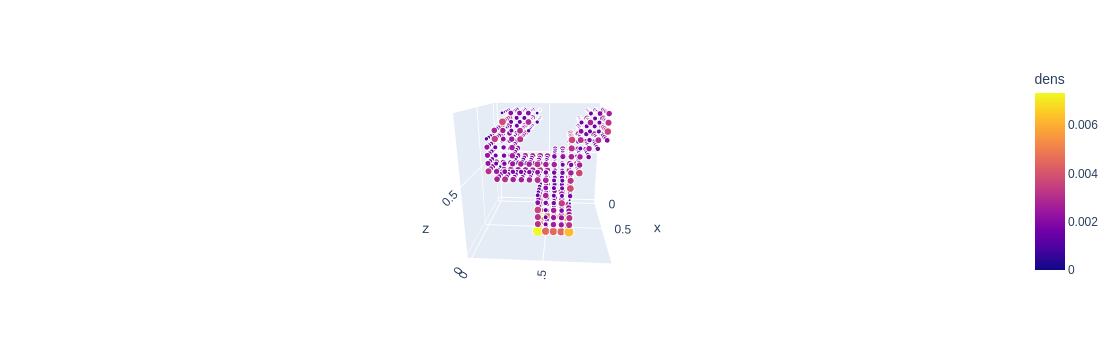

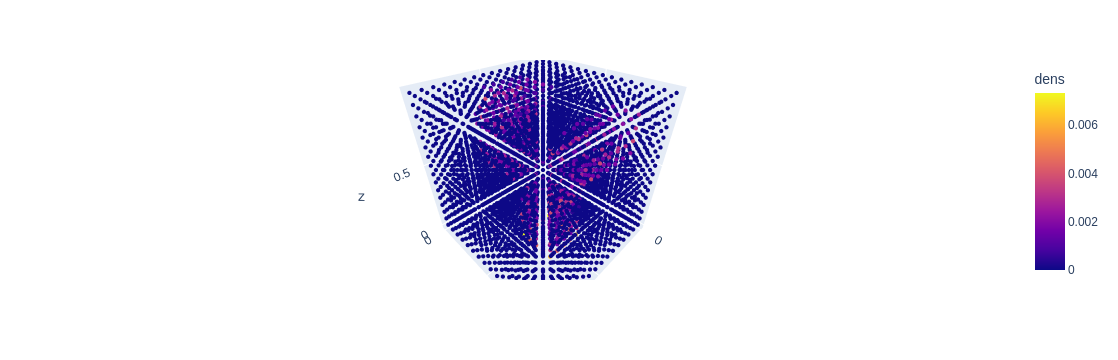

In [234]:
import plotly.express as px
import pandas as pd

c = cube(hf_test['6']['points'][:, : ])
frame = pd.DataFrame()
x_f = []
y_f = []
z_f = []
dens = []
for x in range(16):
    for y in range(16):
        for z in range(16):
            x_f.append( x*0.0625)
            y_f.append(y*0.0625)
            z_f.append(z*0.0625)
            dens.append(c[x][y][z] )
frame['x'] = x_f
frame['y'] = y_f
frame['z'] = z_f
frame['dens'] = dens

fig = px.scatter_3d(frame, x='x', y='y', z='z', color='dens', size='dens', size_max=10, opacity=1)
#fig.update_traces(marker_size=0.5)
fig.show()

fig = px.scatter_3d(frame, x='x', y='y', z='z', color='dens', range_color=[0.1,0], size_max=1)
fig.update_traces(marker_size=1.4)
fig.show()

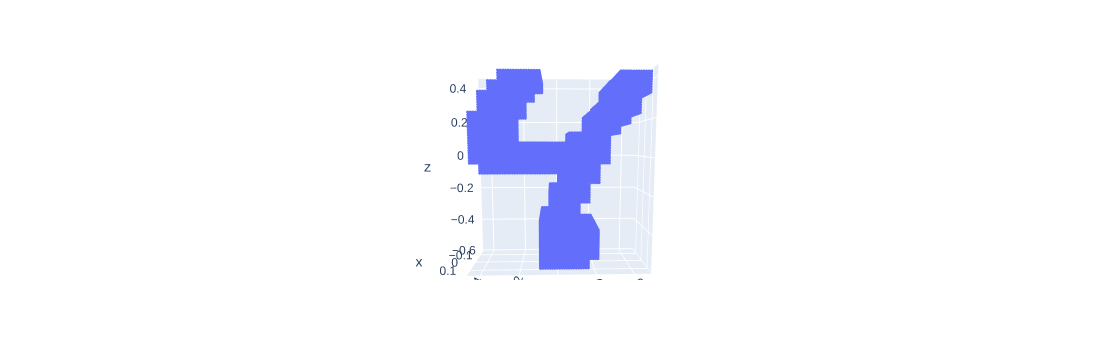

In [263]:
import plotly.express as px
import pandas as pd
d = pd.DataFrame(hf_test['6']['points'][:, : ], columns=['x', 'y', 'z'])

fig = px.scatter_3d(d, x='x', y='y', z='z')
fig.update_traces(marker_size=1)
fig.show()